In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
# Function gets the energy based on a sphere of radius radius_threshold
def GetBlobEnergyRadius(parts_elec, hits_all, end, radius_threshold):
    
    # Get coordinates if the start/end
    if (end == "start"):
        start_coord = parts_elec[['initial_x', 'initial_y', 'initial_z']].values
    else:
        start_coord = parts_elec[['final_x', 'final_y', 'final_z']].values

    # Calculate the Euclidean distance from each row
    distances = np.sqrt(((hits_all[['x', 'y', 'z']].values[:, None] - start_coord) ** 2).sum(axis=2))

    # Find rows where any distance is within the threshold, then sum their energy
    mask = (distances < radius_threshold).any(axis=1)
    result = hits_all[mask]
    return result.energy.sum()


def SortBlobs(blob1_E, blob2_E):

    if (blob1_E > blob2_E):
        return blob1_E, blob2_E
    else:
        return blob2_E, blob1_E


def GetPrimaryKE(parts, hits, particle_id, delta_thresh):

    # Get the energy of the parent particle
    tot_E = hits[hits.particle_id == particle_id].energy.sum()

    # Get all the daughters of the particle
    daughter_pids = parts[ (parts.mother_id == particle_id) & (parts.kin_energy <= delta_thresh) & (parts.particle_name == "e-")].particle_id.unique()

    # Loop over daughters
    for daughter in daughter_pids:

        # Get any particles who have a mother that is the daughter and is in threshold
        daughter_part = parts[ (parts.mother_id == daughter) & (parts.kin_energy <= delta_thresh) & (parts.particle_name == "e-")].particle_id.unique()

        # If there are daughers to the daughter then cycle
        if (len(daughter_part) > 0):
            daughter_E = GetPrimaryKE(parts, hits, daughter, delta_thresh)
        # Otherwise we can add the energy as is
        else:
            daughter_E = hits[hits.particle_id == daughter].energy.sum()
        
        tot_E = tot_E+daughter_E

    return tot_E


def CalcTrackExtent(hits):

    diff = hits.groupby('event_id').agg({
        'x': lambda x: x.max() - x.min(),
        'y': lambda y: y.max() - y.min(),
        'z': lambda z: z.max() - z.min()
    }).reset_index()

    # Rename columns
    diff.rename(columns={'x': 'dx', 'y': 'dy', 'z': 'dz'}, inplace=True)

    diff["Diam"] = np.sqrt((diff.dx)**2 + (diff.dy)**2 + (diff.dz)**2)

    return diff["Diam"]





In [7]:
# load in the particles table

pressure = 1

parts_0nubb = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_nexus_1.h5", "MC/particles")
hits_0nubb  = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_nexus_1.h5", "MC/hits")

# parts_0nubb = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_15bar_nexus_9_2.h5", "MC/particles")
# hits_0nubb  = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_15bar_nexus_9_2.h5", "MC/hits")


parts_Bkg = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_nexus_2954.h5", "MC/particles")
hits_Bkg  = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_nexus_2954.h5", "MC/hits")


# parts_Bkg = parts_Bkg[(parts_Bkg.event_id == 103725000)]
# hits_Bkg = hits_Bkg[(hits_Bkg.event_id == 103725000)]

# pd.set_option("display.max_rows", 1000)
# parts_0nubb = parts_0nubb[(parts_0nubb.event_id == 302)]
# hits_0nubb = hits_0nubb[(hits_0nubb.event_id == 302)]
# display(parts_0nubb[parts_0nubb.primary == 1])



# display(parts_Bkg[(parts_Bkg.event_id == 103725000) & (parts_Bkg.kin_energy > 1)])
# display(hits_Bkg)

# parts_Bkg = pd.read_hdf(f"/Users/mistryk2/Packages/nexus/workdir/XeSphere/XeSphere_1bar.h5", "MC/particles")
# hits_Bkg  = pd.read_hdf(f"/Users/mistryk2/Packages/nexus/workdir/XeSphere/XeSphere_1bar.h5", "MC/hits")


def GetTrueInfoSignal(parts, hits):

    lengths  = []
    energies = []
    energies1 = [] # 0.1 MeV Delta thresh
    energies2 = [] # 0.2 MeV Delta thresh
    energies3 = [] # 0.5 MeV Delta thresh
    blob1_Es = []
    blob2_Es = []
    creator_procs = []
    event_ids = []

    for eid in parts.event_id.unique():

        # print("\n\n On event:", eid)

        part_event = parts[parts.event_id == eid]
        hits_event = hits[hits.event_id == eid]
        electron1  = part_event[part_event.particle_id == 1]
        electron2  = part_event[part_event.particle_id == 2]

        electron1_E = hits_event[hits_event.particle_id == 1].energy.sum()
        electron2_E = hits_event[hits_event.particle_id == 2].energy.sum()

        length = electron1.length.iloc[0]     + electron2.length.iloc[0] # total length

        tot_KE  = GetPrimaryKE(part_event, hits_event, 1, 2.6) +  GetPrimaryKE(part_event, hits_event, 2, 2.6)
        tot_KE1 = GetPrimaryKE(part_event, hits_event, 1, 0.1) +  GetPrimaryKE(part_event, hits_event, 2, 0.1)
        tot_KE2 = GetPrimaryKE(part_event, hits_event, 1, 0.2) +  GetPrimaryKE(part_event, hits_event, 2, 0.2)
        tot_KE3 = GetPrimaryKE(part_event, hits_event, 1, 0.5) +  GetPrimaryKE(part_event, hits_event, 2, 0.5)
        # tot_KE = electron1_E + electron2_E # total energy

        blob1_E =  GetBlobEnergyRadius(electron1, hits_event, "end", 180/pressure)
        blob2_E =  GetBlobEnergyRadius(electron2, hits_event, "end",   180/pressure)
        blob1_E, blob2_E = SortBlobs(blob1_E, blob2_E) # Make sure the blohE are labelled properly

        # print("Length:", length, "mm")
        # print("Tot Energy:", tot_KE, "MeV")
        # print("Blob1 Energy:", blob1_E, "MeV")
        # print("Blob2 Energy:", blob2_E, "MeV")

        lengths.append(length)
        energies.append(tot_KE)
        energies1.append(tot_KE1)
        energies2.append(tot_KE2)
        energies3.append(tot_KE3)
        blob1_Es.append(blob1_E)
        blob2_Es.append(blob2_E)
        creator_procs.append("DBD")
        event_ids.append(eid)

    TrackDiam = CalcTrackExtent(hits[ (hits.particle_id == 1) | (hits.particle_id == 2) ] )

    return pd.DataFrame({ "event_id": event_ids, "TrackLength" : lengths, "TrackEnergy" : energies, "TrackEnergy1" : energies1,  "TrackEnergy2" : energies2, "TrackEnergy3" : energies3,  "Blob1E" : blob1_Es, "Blob2E" :blob2_Es, "TrackDiam" :TrackDiam, "CreatorProc" :creator_procs})


def GetTrueInfoBackground(parts, hits):

    lengths  = []
    energies = []
    blob1_Es = []
    blob2_Es = []
    creator_procs = []
    event_ids = []


    for eid in parts.event_id.unique():

        # print("\n\n On event:", eid)

        part_event = parts[parts.event_id == eid]

        # Here we get the row with the largest electron energy and call that the primary
        part_event = part_event[part_event.particle_name == "e-"]
        parts_primary = part_event.loc[[part_event['kin_energy'].idxmax()]]
        primary_part_id = parts_primary.particle_id.iloc[0]
        
        hits_event = hits[hits.event_id == eid]
        electron1  = part_event[part_event.particle_id == primary_part_id]
        creator_proc = electron1.creator_proc.iloc[0]


        tot_KE = GetPrimaryKE(part_event, hits_event, primary_part_id, 0.1)
        # tot_KE = hits_event[hits_event.particle_id == primary_part_id].energy.sum()

        length = electron1.length.iloc[0] # total length

        blob1_E =  GetBlobEnergyRadius(electron1, hits_event, "start", 180/pressure)
        blob2_E =  GetBlobEnergyRadius(electron1, hits_event, "end",   180/pressure)
        blob1_E, blob2_E = SortBlobs(blob1_E, blob2_E) # Make sure the blohE are labelled properly

        # print("Length:", length, "mm")
        # print("Tot Energy:", tot_KE, "MeV")
        # print("Blob1 Energy:", blob1_E, "MeV")
        # print("Blob2 Energy:", blob2_E, "MeV")

        lengths.append(length)
        energies.append(tot_KE)
        blob1_Es.append(blob1_E)
        blob2_Es.append(blob2_E)
        creator_procs.append(creator_proc)
        event_ids.append(eid)

    TrackDiam = CalcTrackExtent(hits[ hits.particle_id == primary_part_id])

    return pd.DataFrame({ "event_id": event_ids, "TrackLength" : lengths, "TrackEnergy" : energies, "Blob1E" : blob1_Es, "Blob2E" :blob2_Es, "TrackDiam" :TrackDiam, "CreatorProc" :creator_procs})


# df_signal = GetTrueInfoSignal(parts_0nubb, hits_0nubb)
# display(df_signal)


# df_bkg = GetTrueInfoBackground(parts_Bkg, hits_Bkg)
# display(df_bkg)


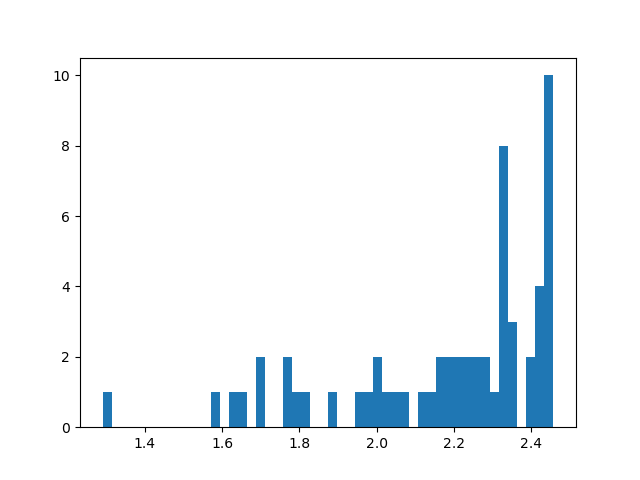

In [97]:
plt.figure()

plt.hist(df_signal.TrackEnergy, bins = 50);


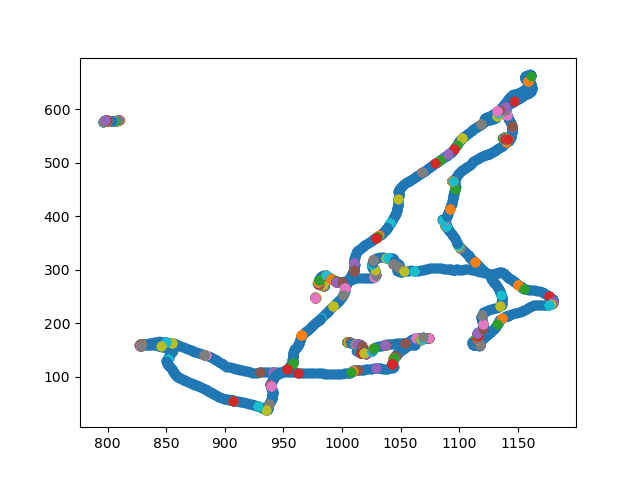

In [8]:
plt.figure()

# events = hits_Bkg.event_id.unique()
# event = hits_Bkg[hits_Bkg.event_id == events[0]]

events = hits_0nubb.event_id.unique()
event = hits_0nubb[hits_0nubb.event_id == events[2]]


# display(event.particle_id.unique())

# print(event[event.particle_id == 1].energy.sum())

# print( GetPrimaryKE(parts_Bkg[parts_Bkg.event_id == events[0]], event, 1))

for p in event.particle_id.unique():
    
    plt.scatter(event[event.particle_id==p].x, event[event.particle_id==p].y)


